# 🟦 多項式回帰

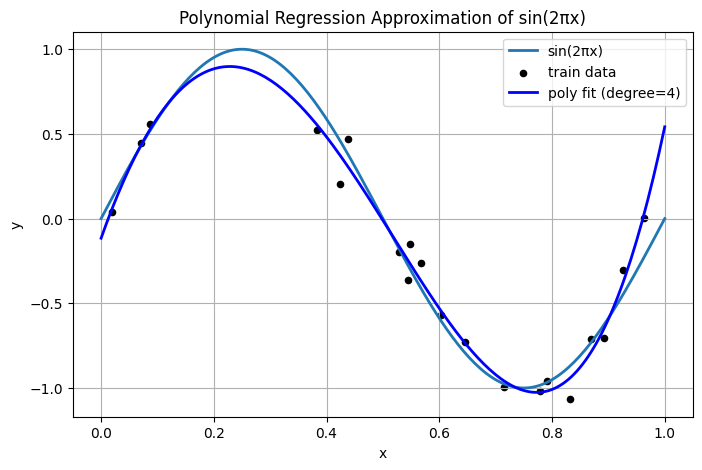

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# ---- 1. 訓練データ作成 ----
np.random.seed(0)
N_train = 20
sigma = 0.1

train_x = np.random.rand(N_train)
train_y = np.sin(2*np.pi*train_x) + np.random.normal(0, sigma, N_train)

# ---- 2. 多項式特徴量の生成 ----
m = 4  # 4次多項式
poly = PolynomialFeatures(degree=m, include_bias=False)
X_train = poly.fit_transform(train_x.reshape(-1,1))

# ---- 3. 多項式回帰モデル学習 ----
model = LinearRegression()
model.fit(X_train, train_y)

# ---- 4. テストデータ生成 & 予測 ----
N_test = 200
test_x = np.linspace(0, 1, N_test)
X_test = poly.transform(test_x.reshape(-1,1))
test_y = model.predict(X_test)

# ---- 5. プロット ----
plt.figure(figsize=(8,5))
# 真の関数
plt.plot(test_x, np.sin(2*np.pi*test_x), label="sin(2πx)", linewidth=2)
# 訓練データ
plt.scatter(train_x, train_y, color="black", s=20, label="train data")
# 予測曲線
plt.plot(test_x, test_y, color="blue", label="poly fit (degree=4)", linewidth=2)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Polynomial Regression Approximation of sin(2πx)")
plt.grid(True)
plt.show()


### 🟠 PolynomialFeaturesとは何か

* 入力された一次元または多次元の特徴量を、多項式の形に拡張するための前処理
* x を受け取り、x, x², x³,… といった新しい特徴量を自動生成する
* scikit-learn の前処理クラスで、線形回帰と組み合わせて多項式回帰を実現する


引数

* degree
  * 生成する多項式の次数
* include_bias
  * 切片項を含めるかどうか
* interaction_only
  * 交差項のみを作るかどうか
* order
  * 多項式を生成する順序の指定（rareに使う）


返り値

* fit_transform後に返るのは多項式化された特徴量行列
  * 例：入力が [x] で degree=3 のとき
    [x, x², x³]
  * 例：入力が [x1, x2] で degree=2 のとき
    [x1, x2, x1², x1x2, x2²]


### 🟠 普通の回帰分析との違い

* 普通の回帰分析
  * そのままの特徴量に対して線形モデルを当てはめる
* 多項式回帰（PolynomialFeaturesを使う場合）
  * 特徴量を人工的に増やし、非線形の形状を線形モデルで表現できるようにする
* 違いの本質
  * 元の線形回帰モデル自体は線形のまま
  * 特徴量を多項式化することで、結果的に非線形の関数形を近似できるようになる


# 🟦 回帰係数の検定

$\mathbf{Y_i = 0 \cdot X_{1i} + 0 + \epsilon_i}$ （水平の関数）で $\epsilon_i$ には均0、分散1の正規分布に従う乱数を設定した関数を真のモデルとする

これは X と Y に相関があるかを検定している

上記のモデルに対して単回帰分析を1000回繰り返し  
回帰係数の推定値の分布が理論（t分布・F分布）に一致することを確かめる

* この単回帰分析では **aとbの推定値** を求める
* 単回帰分析では **最小二乗法** を用いる
* 最小二乗法によって得られる推定値 $\hat{a}$ や $\hat{b}$ は、誤差項 $\epsilon_i$ が正規分布に従うという仮定の下で、それ自体が正規分布に従います。
* $\hat{a}$ の標準偏差 $\sigma_{\hat{a}}$（真の標準誤差）が分からないため、標本標準誤差 $\hat{\sigma}_{\hat{a}}$ を用いて **t統計量** に変換する
* このt統計量が自由度 $n-2$ の **$t$分布に従う**
* F統計量
    * 回帰分析において、「すべての説明変数（回帰係数）が目的変数に対して影響を与えていない（係数がすべてゼロである）」という**帰無仮説**を検定します
    * **F値が大きい**場合、偶然にその値が得られる確率は低くなり、**帰無仮説を棄却**する根拠が強くなります。

---

* Ta, Tb は t 分布 と一致するはず
* F は F 分布 と一致するはず

---

* `np.random.normal(0, 1, samplesize)`
    * 平均 0、分散 1 の正規分布に従う乱数

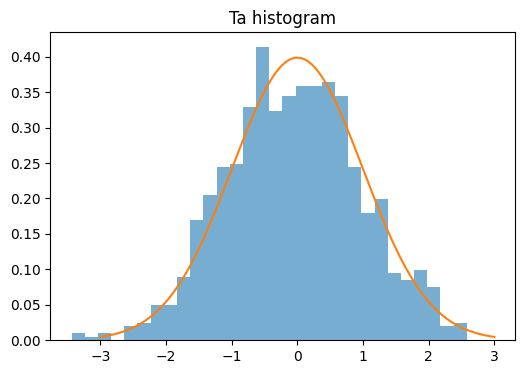

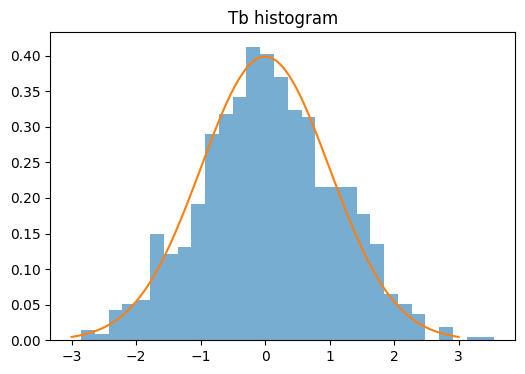

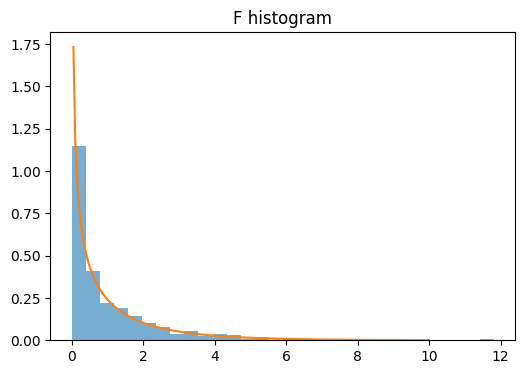

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, f

#-----------------------------
# パラメータ設定
#-----------------------------
np.random.seed(5)
true_a = 0
true_b = 0
samplesize = 250
trial = 1000

x1 = np.random.rand(samplesize)

sim_Ta = np.zeros(trial)
sim_Tb = np.zeros(trial)
sim_F  = np.zeros(trial)

#-----------------------------
# シミュレーション
#-----------------------------
for i in range(trial):
    x2 = np.random.normal(0, 1, samplesize)
    y1 = true_a * x1 + true_b + x2

    # 回帰
    X = np.vstack([np.ones(samplesize), x1]).T
    coef = np.linalg.inv(X.T @ X) @ (X.T @ y1)
    bhat = coef[0]
    ahat = coef[1]
    yhat = X @ coef
    residuals = y1 - yhat

    SX = np.sum((x1 - x1.mean())**2)
    SR = np.sum((yhat - y1.mean())**2)
    ST = np.sum(residuals**2)

    MSR = SR / 1
    MST = ST / (samplesize - 2)
    sim_F[i] = MSR / MST

    sigmahat = np.sqrt(ST / (samplesize - 2))
    sigma_a = sigmahat / np.sqrt(SX)
    sigma_b = sigmahat * np.sqrt(1/samplesize + (x1.mean()**2)/SX)

    sim_Ta[i] = (ahat - true_a) / sigma_a
    sim_Tb[i] = (bhat - true_b) / sigma_b

#-----------------------------
# Ta のヒストグラム
#-----------------------------
plt.figure(figsize=(6,4))
plt.hist(sim_Ta, bins=30, density=True, alpha=0.6)
x = np.linspace(-3,3,200)
plt.plot(x, t.pdf(x, df=samplesize-2))
plt.title("Ta histogram")
plt.show()

#-----------------------------
# Tb のヒストグラム
#-----------------------------
plt.figure(figsize=(6,4))
plt.hist(sim_Tb, bins=30, density=True, alpha=0.6)
plt.plot(x, t.pdf(x, df=samplesize-2))
plt.title("Tb histogram")
plt.show()

#-----------------------------
# F のヒストグラム
#-----------------------------
plt.figure(figsize=(6,4))
plt.hist(sim_F, bins=30, density=True, alpha=0.6)
x_F = np.linspace(0,10,200)
plt.plot(x_F, f.pdf(x_F, dfn=1, dfd=samplesize-2))
plt.title("F histogram")
plt.show()


# 🟦 信頼区間

* statsmodels
    * 統計解析ライブラリ
    * 回帰係数の推定だけでなく、信頼区間・標準誤差・p値 など統計量を自動で計算してくれる
* 

/home/kuni/Documents/computer-vision-practices/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kuni/Documents/computer-vision-practices/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38972 (\N{CJK UNIFIED IDEOGRAPH-983C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kuni/Documents/computer-vision-practices/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kuni/Documents/computer-vision-practices/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kuni/D

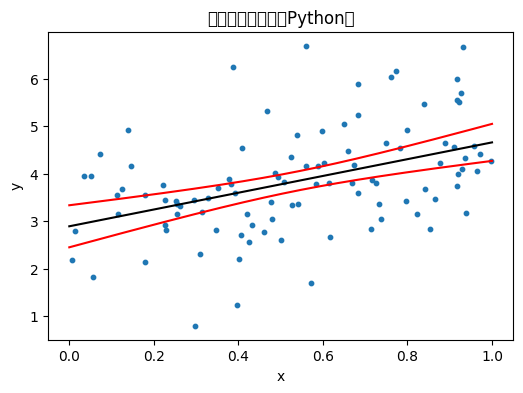

        fit       lwr       upr
0  2.891747  2.448531  3.334963
1  2.893517  2.450951  3.336083
2  2.895288  2.453371  3.337204
3  2.897058  2.455791  3.338326
4  2.898829  2.458211  3.339447
5  2.900600  2.460630  3.340569


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# 乱数シード
np.random.seed(50)

# 真の係数
true_a = 2
true_b = 3

# データサイズ
samplesize = 100
testsize = 1000

# 説明変数 x1（一様分布）
x1 = np.random.rand(samplesize)

# 誤差項 x2（正規分布）
x2 = np.random.normal(loc=0, scale=1.0, size=samplesize)

# 目的変数 y
y1 = true_a * x1 + true_b + x2

# 学習データ
train = pd.DataFrame({"x": x1, "y": y1})

# 線形回帰（statsmodels：信頼区間を得やすいため）
X = sm.add_constant(train["x"])
model = sm.OLS(train["y"], X).fit()

# 予測用データ
x_test = np.linspace(0, 1, testsize)
X_test = sm.add_constant(x_test)

# 予測 & 信頼区間
pred = model.get_prediction(X_test).summary_frame(alpha=0.05)
fit = pred["mean"]
lwr = pred["mean_ci_lower"]
upr = pred["mean_ci_upper"]

# 可視化
plt.figure(figsize=(6,4))
plt.scatter(train["x"], train["y"], s=10)
plt.plot(x_test, fit, color="black")
plt.plot(x_test, lwr, color="red")
plt.plot(x_test, upr, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.title("信頼区間の表示（Python）")
plt.show()

# 最初の数行を R の head() と同じように表示
print(pd.DataFrame({"fit": fit, "lwr": lwr, "upr": upr}).head(6))
